# PyTesseract Image Processing

In [1]:
import cv2
import pytesseract
from PIL import Image

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r'C:\Users\derek\School\DataRes\Tesseract-OCR\tesseract.exe'

# Scanning with PyTesseract without Pre-Processing

In [3]:
# read image
im = cv2.imread('test1.png')

# configurations
config = ('-l eng --oem 3 --psm 4')

# pytessercat
text = pytesseract.image_to_string(im, config=config)

# print text
text = text.split('\n')
text

['Sauvignon Blane', '']

# Pre-Image Processing Function

In [12]:
def preprocess(img):
    # Increase the resolution
    img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    equalized = clahe.apply(gray)

    # Bilateral filtering
    filter = cv2.bilateralFilter(equalized,9,75,75)

    # Apply adaptive thresholding to convert the image to binary
    binary = cv2.adaptiveThreshold(filter, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Apply dilation to fill in gaps in characters
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilation = cv2.dilate(binary, kernel, iterations=1)

    # Apply erosion to remove small noise
    erosion = cv2.erode(dilation, kernel, iterations=1)
    
    # Gaussian Blur 
    blur = cv2.GaussianBlur(filter, (5, 5), 0)
    
    return [img, equalized, filter, binary, dilation, erosion, blur]

# Displaying Images Function

In [13]:
# Display the results using matplotlib
def display_img (img):# Display the results using matplotlib
    fig, axs = plt.subplots(3, 3, figsize=(10, 8))
    fig.suptitle('Preprocessed Images')
    axs[0, 0].imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Input Image')
    axs[0, 1].imshow(img[1], cmap='gray')
    axs[0, 1].set_title('Equalized Image')
    axs[0, 2].imshow(img[2], cmap='gray')
    axs[0, 2].set_title('Filtered Image')
    axs[1, 0].imshow(img[3], cmap='gray')
    axs[1, 0].set_title('Binary Image')
    axs[1, 1].imshow(img[4], cmap='gray')
    axs[1, 1].set_title('Dilated Image')
    axs[1, 2].imshow(img[5], cmap='gray')
    axs[1, 2].set_title('Eroded Image')
    axs[2,0].imshow(img[6], cmap = 'gray')
    axs[2,0].set_title('Gaussian Blur')
    for ax in axs.flat:
        ax.axis('off')
    plt.show()

# Output of Image Processing Function

In [51]:
wine_types = {
    "riesling":"Riesling", "noir":"Pinot Noir", "blanc":"Sauvignon Blanc", 
    "chardonnay":"Chardonnay", "gris":"Pinot Gris", "zinfandel":"Zinfandel",
    "syrah":"Syrah", "blanc":"Cabernet Sauvignon", "sauvignon":"Cabernet Sauvignon", "champagne":"Champagne", 
    "pinot": "Gris or Noir"
}

# Perform OCR on the preprocessed image
def ocr_text (img_list):
    img_type = ['Input', 'Equalized', 'Filtered', 'Binary', 'Dilated', 'Eroded', 'Gaussian Blur', 'Rotated']
    text = pytesseract.image_to_string(img_list[2], config=config)
    text = text.split('\n')
    text = [words for segments in text for words in segments.split()]
    while("" in text):
        text.remove("")
        
    # Taking out all special characters & making lower case
    text2 = [re.sub(r'[^\w]', '', x).lower() for x in text]
    print(text2)
    
    
    # Finding all Wine Information
    wine_info = {
        "Name": [],
        "Year": [],
        "Wine_Type": []
    }
    for j in text2:
        for key, value in wine_types.items():
            if key in j:
                wine_info["Wine_Type"] = value
                text2.remove(j)
        if ((j.isdigit()) and (len(j) >= 4)):
            wine_info["Year"] = j
            text2.remove(j)
    wine_info["Name"] = " ".join(text2)

    # if can't find wine type or year
    if wine_info["Wine_Type"] == []:
        print("Can't Find Wine Type")
    if wine_info["Year"] == []:
        print("Can't Find Year")
        
    print(wine_info)

    
    '''
    Print out all outputs from preprocessing function
    for i in range(7):
        text = pytesseract.image_to_string(img_list[i], config=config)
        text = text.split('\n')
        if (len(text) < 100):
            # Print the OCR results
            print(str(img_type[i]) + str(text))
    '''
    

# Output of Functions & Testing

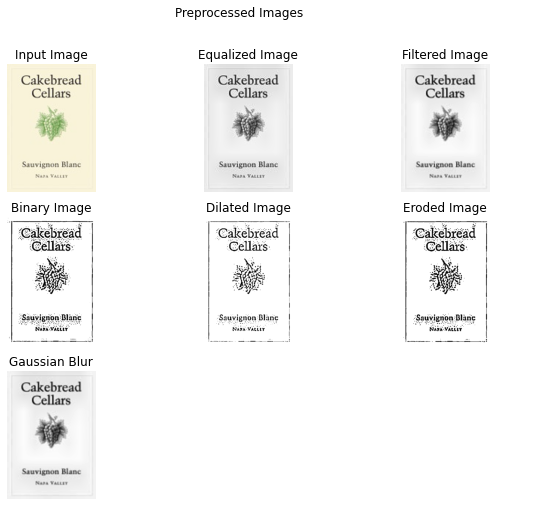

['cakebread', 'cellars', 'iw', 'sauvignon', 'blanc', 'nara', 'valier']
Can't Find Year
{'Name': 'cakebread cellars iw blanc nara valier', 'Year': [], 'Wine_Type': 'Cabernet Sauvignon'}


In [54]:
im = cv2.imread('test1.png')
img_list = preprocess(im)
display_img(img_list)
ocr_text(img_list)